In [77]:
import sympy as sp
import numpy as np
import control as ct
from IPython.display import display, Latex, Math, Image
def generate_matrix(vector, factors):
    return sp.Matrix([[sp.collect(sp.expand(vector[j]), factors).coeff(x) 
                 for x in factors] for j in range(len(factors))])


def eq_disp(varstring, expr):
    display(Latex(f"${varstring}={sp.latex(expr)}$"))

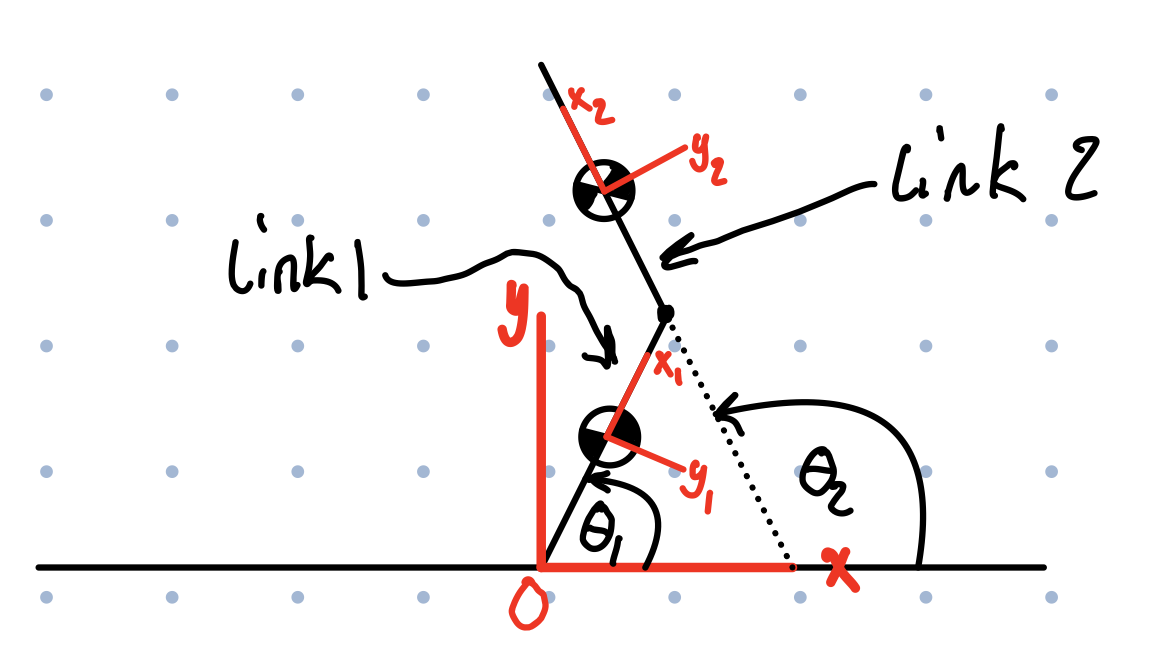

In [78]:
Image("FBD.png")

In [79]:
s, g, t, m1, m2, J1, J2, c1, c2, l1, l2 = sp.symbols(r"s, g, t, m1, m2, J_1, J_2 c_1, c_2, l_1, l_2")
s = sp.symbols('s')
theta1 = sp.Function('theta_1')(t)
theta2 = sp.Function('theta_2')(t)
tau1 = sp.Function('tau_1')(t)
tau2 = sp.Function('tau_2')(t)

dtheta1 = theta1.diff(t)
dtheta2 = theta2.diff(t)
ddtheta1 = dtheta1.diff(t)
ddtheta2 = dtheta2.diff(t)
q = sp.Matrix([theta1, theta2])
dq = q.diff(t)
def A(theta):
    return sp.Matrix([
        [sp.cos(theta), -sp.sin(theta)], 
        [sp.sin(theta), sp.cos(theta)]])
L1 = sp.Matrix([l1, 0])
L2 = sp.Matrix([l2, 0])
""" J1 = sp.Rational(1,12)*m1*l1**2
J2 = sp.Rational(1,12)*m2*l2**2 """

' J1 = sp.Rational(1,12)*m1*l1**2\nJ2 = sp.Rational(1,12)*m2*l2**2 '

In [119]:
int(12).to_bytes(2, "little").hex()

'0c00'

Physical properties

In [80]:
m1v = 0.269
m2v = 0.511
L1v = 0.307
L2v = 0.307
J1v = 1/12*m1v*L1v**2
J2v = 1/12*m2v*L2v**2
c1v = 0.1
c2v = 0.1
properties = {
    m1: m1v,
    m2: m2v,
    l1: L1v,
    l2: L2v,
    J1: J1v,
    J2: J2v,
    c1: c1v,
    c2: c2v,
    g: 9.82
}

define x and y of the centroid of the two bodies

In [81]:
x1, y1= A(theta1)*sp.Rational(1,2)*L1 
x2, y2 = A(theta1)*L1 + A(theta2)*sp.Rational(1,2)*L2

In [82]:
T_rot = sp.Rational(1,2)*(J1*dtheta1**2 + J2*dtheta2**2)
T_trans = sp.Rational(1,2)*(m1*(x1.diff(t)**2 + y1.diff(t)**2) + m2*(x2.diff(t)**2 + y2.diff(t)**2))
T = T_rot + T_trans
R = sp.Rational(1,2)*(c1*dtheta1**2 + c2*dtheta2**2)  # friction as function of rotational velocity
U = m1*g*y1 + m2*g*y2
L = T-U
eq1, eq2 = L.diff(dq).diff(t) - L.diff(q) + R.diff(dq)

## Find the state space representation

solve for $[\ddot{\theta_1}, \ddot{\theta_2}]$ from the lagrange equations

In [83]:
sol = sp.solve([eq1, eq2], (ddtheta1, ddtheta2), simplify=True)

In [84]:
ddq = sp.Matrix([sol[ddtheta1], sol[ddtheta2]])
ddq

Matrix([
[                                                                                                         (-16*J_2*c_1*Derivative(theta_1(t), t) - 8*J_2*g*l_1*m1*cos(theta_1(t)) - 16*J_2*g*l_1*m2*cos(theta_1(t)) - 8*J_2*l_1*l_2*m2*sin(theta_1(t) - theta_2(t))*Derivative(theta_2(t), t)**2 - 4*c_1*l_2**2*m2*Derivative(theta_1(t), t) + 8*c_2*l_1*l_2*m2*cos(theta_1(t) - theta_2(t))*Derivative(theta_2(t), t) - 2*g*l_1*l_2**2*m1*m2*cos(theta_1(t)) + 2*g*l_1*l_2**2*m2**2*cos(theta_1(t) - 2*theta_2(t)) - 2*g*l_1*l_2**2*m2**2*cos(theta_1(t)) - 2*l_1**2*l_2**2*m2**2*sin(2*theta_1(t) - 2*theta_2(t))*Derivative(theta_1(t), t)**2 - 2*l_1*l_2**3*m2**2*sin(theta_1(t) - theta_2(t))*Derivative(theta_2(t), t)**2)/(16*J_1*J_2 + 4*J_1*l_2**2*m2 + 4*J_2*l_1**2*m1 + 16*J_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2 - 2*l_1**2*l_2**2*m2**2*cos(2*theta_1(t) - 2*theta_2(t)) + 2*l_1**2*l_2**2*m2**2)],
[(-16*J_1*c_2*Derivative(theta_2(t), t) - 8*J_1*g*l_2*m2*cos(theta_2(t)) + 8*J_1*l_1*l_2*m2*sin(theta_1(t) - thet

Our state variables are:
$$z =[z_1, z_2, z_3, z_4]=[\theta_1, \theta_2, \dot{\theta_1}, \dot{\theta_2}]$$
our inputs are:
$$u = [\tau_1, \tau_2]$$
Now we can define the system of differential equations $\dot{z}$

In [85]:
z1, z2, z3, z4 = sp.symbols("z_1, z_2, z_3, z_4", cls=sp.Function)
z1=z1(t); z2=z2(t); z3=z3(t); z4=z4(t)
z = sp.Matrix([z1, z2, z3, z4])
state_space = {
    theta1: z1,
    theta2: z2,
    dtheta1: z3,
    dtheta2: z4
}
C = sp.Matrix([
    [0, 0],
    [0, 0],
    [1, 0],
    [0, 1]
])
u = sp.Matrix([tau1, tau2])
dz = sp.Matrix([z[2], z[3], ddq[0].subs(state_space), ddq[1].subs(state_space)]) +C@u
dz

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               z_3(t)],
[                                                                                                                                                                                                                                                                                                                                     

Now the jacobian with regards to the state variables is

In [86]:
Jstate = dz.jacobian(z)
Jstate

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

The jacobian with regards to the inputs is

In [87]:
Jinput = dz.jacobian(u)
Jinput

Matrix([
[0, 0],
[0, 0],
[1, 0],
[0, 1]])

## Finding equilibrium point to linearlize about.
The equilibrium position $(\theta_1, \theta_2)$ can be chosen abitrarily to let us calculate the necessary constant motor torque to maintain this position.
The relationship between torque and the angle is given by:

In [88]:
def u_at_z0(tet1, tet2):
    at_rest = {
        z1: tet1, 
        z2: tet2, 
        z3: 0, 
        z4: 0, }
    eqlb_p = sp.solve(dz.subs(at_rest), {tau1, tau2})
    tau0 = sp.Matrix([eqlb_p[tau1], eqlb_p[tau2]])
    return tau0

At the point of expansion $\dot{z}=0$ by defintion since we chose a steady state as the operating point.  
Also if we redefine to measure $(\theta_1, \theta_2)$ from the operating point we get 
$$z_0=[0,0,0,0]$$
in which case we can simplify $(z-z_0)=z$.

In [89]:
z0 = sp.Matrix([0, 0, 0, 0])
u0 = u_at_z0(z0[0], z0[1])
lin_dz = Jstate.subs(zip(z, z0))@(z) + Jinput.subs(zip(u, u0))@(u)
lin_dz

Matrix([
[                                                                                                                                                                                                                                                                            z_3(t)],
[                                                                                                                                                                                                                                                                            z_4(t)],
[                   8*c_2*l_1*l_2*m2*z_4(t)/(16*J_1*J_2 + 4*J_1*l_2**2*m2 + 4*J_2*l_1**2*m1 + 16*J_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2) + (-16*J_2*c_1 - 4*c_1*l_2**2*m2)*z_3(t)/(16*J_1*J_2 + 4*J_1*l_2**2*m2 + 4*J_2*l_1**2*m1 + 16*J_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2) + tau_1(t)],
[8*c_1*l_1*l_2*m2*z_3(t)/(16*J_1*J_2 + 4*J_1*l_2**2*m2 + 4*J_2*l_1**2*m1 + 16*J_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2) + (-16*J_1*c_2 - 4*c_2*l_1**2*m1 - 16*c_2*

In [90]:
def LPT(x):
    return sp.laplace_transform(x, t, s)

In [91]:
ics = {
    theta1.subs(t, 0): 0,
    theta2.subs(t, 0): 0,
    dtheta1.subs(t,0): 0,
    dtheta2.subs(t,0): 0,
    ddtheta1.subs(t,0): 0,
    ddtheta2.subs(t,0): 0
}
inv_state_space = {v: k for k,v in state_space.items()}
variables = sp.Matrix([theta1, theta2, tau1, tau2])
s_variables = [x.subs(t, s) for x in variables]
L_variables = [sp.laplace_transform(x, t, s) for x in [theta1, theta2, tau1, tau2]]
Y = (
    Jstate.subs(zip(z, z0))@LPT(z.subs(inv_state_space)) 
    - LPT(z.diff(t).subs(inv_state_space)) 
    + Jinput.subs(zip(u, u0))@LPT(u)).subs(ics)
Y

C:\Users\osteb\AppData\Local\Temp\ipykernel_30508\1244304805.py:2: SymPyDeprecationWarning: 

Calling laplace_transform() on a Matrix with noconds=False (the default) is
deprecated. Either noconds=True or use legacy_matrix=False to get the new
behavior.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-laplace-transform-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  return sp.laplace_transform(x, t, s)
C:\Users\osteb\AppData\Local\Temp\ipykernel_30508\1244304805.py:2: SymPyDeprecationWarning: 

Calling laplace_transform() on a Matrix with noconds=False (the default) is
deprecated. Either noconds=True or use legacy_matrix=False to get the new
behavior.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-laplace-transform-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  return 

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                               0],
[                                                                                                                                                                                                                                                                                                                                                                                                               0],
[                   8*c_2*l_1*l_2*m2*s*LaplaceTransform(theta_2(t), t, s)/(16*J_1*J_2 + 4*J_1*l_2**2*m2 + 4*J_2*l_1**2*m1 + 16*J_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2) - s**2*LaplaceTrans

In [92]:
Y = Y.subs(zip(L_variables, s_variables))
Y

Matrix([
[                                                                                                                                                                                                                                                                                                               0],
[                                                                                                                                                                                                                                                                                                               0],
[                   8*c_2*l_1*l_2*m2*s*theta_2(s)/(16*J_1*J_2 + 4*J_1*l_2**2*m2 + 4*J_2*l_1**2*m1 + 16*J_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2) - s**2*theta_1(s) + s*(-16*J_2*c_1 - 4*c_1*l_2**2*m2)*theta_1(s)/(16*J_1*J_2 + 4*J_1*l_2**2*m2 + 4*J_2*l_1**2*m1 + 16*J_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2) + tau_1(s)],
[8*c_1*l_1*l_2*m2*s*theta_1(s)/(16*J_1*J_2 + 4*J_1*l_2**2*m2 + 4*J_

In [93]:
theta1_s, theta2_s, tau1_s, tau2_s = s_variables

In [94]:
sol = sp.solve(Y, (tau1_s, tau2_s), simplify=True)
for k,v in sol.items():
    eq_disp("\\"+k.__repr__(), v.subs(properties))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The equations for $\theta_1(s)$ and $\theta_2(s)$ are coupled. To simplify we treat the contribution from the other variable as a disturbance

In [95]:
def remove_term(expr, term):
    new_expr = expr.subs(term, 0)
    return new_expr

tau1 = remove_term(sol[tau1_s], theta2_s)
tau2 = remove_term(sol[tau2_s], theta1_s)
eq_disp(r"\theta_1(s)", theta1)
eq_disp(r"\theta_2(s)", theta2)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We can then find the transfer functions for the dynamics

In [96]:
T1s = ((tau1/theta1_s)**-1).simplify()
T2s = ((tau2/theta2_s)**-1).simplify()
eq_disp(r"\frac{\theta_1(s)}{\tau_1(s)}", T1s)
eq_disp(r"\frac{\theta_2(s)}{\tau_2(s)}", T2s)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [123]:
len(bytes([0x3E, 0xA5, 0x05, 0x03, 0xEB, 0x01, 0x74, 0x13, 0x00, 0x88]))

10

In [120]:
sp.python(T2s)

"J_1 = Symbol('J_1')\nJ_2 = Symbol('J_2')\nl_2 = Symbol('l_2')\nm2 = Symbol('m2')\nl_1 = Symbol('l_1')\nm1 = Symbol('m1')\ns = Symbol('s')\nc_2 = Symbol('c_2')\ne = (16*J_1*J_2 + 4*J_1*l_2**2*m2 + 4*J_2*l_1**2*m1 + 16*J_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2)/(s*(16*J_1*J_2*s + 16*J_1*c_2 + 4*J_1*l_2**2*m2*s + 4*J_2*l_1**2*m1*s + 16*J_2*l_1**2*m2*s + 4*c_2*l_1**2*m1 + 16*c_2*l_1**2*m2 + l_1**2*l_2**2*m1*m2*s))"

In [98]:
T1s.subs(properties)

0.00526339499344853/(s*(0.00526339499344853*s + 0.0256859941333333))

In [99]:
T2s.subs(properties)

0.00526339499344853/(s*(0.00526339499344853*s + 0.0905795722666667))

## Numeric modelling
Now we have our linearized state space model, which we can model numerically

In [100]:
sp.Poly(T1s.subs(properties))

Poly(0.00526339499344853*(1/(0.00526339499344853*s**2 + 0.0256859941333333*s)), 1/(0.00526339499344853*s**2 + 0.0256859941333333*s), domain='RR')

In [101]:
num = float(T1s.subs(properties).as_numer_denom()[0])
denom = [float(x) for x in sp.Poly(T1s.subs(properties).as_numer_denom()[1]).all_coeffs()]
display(num, denom)

0.005263394993448534

[0.005263394993448534, 0.025685994133333334, 0.0]

In [102]:
T1 = ct.tf(num, denom)

In [103]:
T1

TransferFunction(array([0.00526339]), array([0.00526339, 0.02568599, 0.        ]))

In [104]:
num = float(T2s.subs(properties).as_numer_denom()[0])
denom = [float(x) for x in sp.Poly(T2s.subs(properties).as_numer_denom()[1]).all_coeffs()]
display(num, denom)

0.005263394993448534

[0.005263394993448534, 0.09057957226666667, 0.0]

In [105]:
T2 = ct.tf(num, denom)
T2

TransferFunction(array([0.00526339]), array([0.00526339, 0.09057957, 0.        ]))